# Tema 1 - A taste for music
## Găsirea genului pentru piese

### Autori: 
* George Muraru
* Alexandru Sorici

## 1. Scopul temei



Tema are ca scop folosirea metodelor de clasificare studiate în cadrul cursului/laboratorului pentru a **determina genul muzical** al unor sample-uri audio dintr-un set de date.

Se dorește înțelegerea procedurii tipice de **prelucrare a unui set de date**, de **explorare a atributelor**, precum și efectuarea unei **analize comparative** a mai multor algoritmi de clasificare, evidențiând diferențele între ei prin metrici precum *acuratețe, precizie, regăsire (eng. recall)*. 

## 2. Set de date

Primul pas în orice problema de data science este încărcarea și "înțelegerea" datelor.

Setul de date utilizat poartă denumirea de Free Music Archive [[1]](#fma). 

Dataset-ul utilizat este "usor" modificat - va conține doar 4 genuri muzicale: *Rock*, *Hip-Hop*, *Folk* și *Electronic*.

Setul de date este deja echilibrat (eng. balanced) -- sunt câte 500 de piese din fiecare gen în setul de train și câte 100 în cel de testare.

Dacă setați parametrul [DOWNLOAD_SAMPLE_DATASET](#scrollTo=te02bqsfMhls) se va descărca și un audio sample pentru fiecare track_id atunci când se rulează celula specifică pentru secțiunea [Descărcare](#scrollTo=RxCYjmzTM82o).

Puteți asculta sample-ul din piesă [aici](#scrollTo=te02bqsfMhls).

Se va folosi drept **clasă** (eticheta care trebuie prezisa) *genul muzical cel mai general* (numele coloanei în engleza este *top_genre*) pentru fiecare piesă.


Setul de date conține pentru fiecare sample mai multe atribute (eng. features), de tip numeric, care pot fi folosite pentru clasificare. Acestea pot fi găsite în fișierele *features.csv* sau *echonest.csv*.


Pentru mai multe informații privind setul de date, se poate consulta [acest repository](https://github.com/mdeff/fma).

Dataset-ul utilizat este o copie ușor modificată a celor [3 dataset-uri](https://github.com/mdeff/fma#Data): *fma_small.zip*, *fma_medium.zip*, *fma_large.zip*.

## 3. Workspace Setup

### Parametrii

In [2]:
# Music samples -- has ~ 2GB
DOWNLOAD_SAMPLE_DATASET = True  #@param {type: "boolean"}

### Dependențe

In [3]:
!python3 -m pip install pandas # needed for loading the dataset
!python3 -m pip install xgboost

if DOWNLOAD_SAMPLE_DATASET:
    !python3 -m pip install ffmpeg # Needed by librosa for mp3
    !python3 -m pip install librosa
    !python3 -m pip install tqdm # Progress bar for dowloading large file
!python3 -m pip install yellowbrick

### Import biblioteci

In [4]:
if DOWNLOAD_SAMPLE_DATASET:
    from tqdm import tqdm
    import librosa

import pandas as pd
from zipfile import ZipFile

import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

### Funcții ajutătoare

In [5]:
def _reporthook(t):
    """ ``reporthook`` to use with ``urllib.request`` that prints the process of the download.

    Uses ``tqdm`` for progress bar.

    **Reference:**
    https://github.com/tqdm/tqdm

    Args:
        t (tqdm.tqdm) Progress bar.
    """
    last_b = [0]

    def inner(b=1, bsize=1, tsize=None):
        """
        Args:
            b (int, optional): Number of blocks just transferred [default: 1].
            bsize (int, optional): Size of each block (in tqdm units) [default: 1].
            tsize (int, optional): Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return inner

def getHomeworkArchives():
    """ Checks if the homework dataset is present in the local directory, if not,
    downloads it.
    """
    from os import path

    dataset_info = {
        "fma_song_info.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_info.zip",
        "fma_song_samples.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_samples.zip" # Need to upload this
    }

    for dataset_file, dataset_url in dataset_info.items():
        if not path.isfile(dataset_file):
            import urllib
            with tqdm(unit='B', unit_scale=True, miniters=1, desc=dataset_file) as t:
                urllib.request.urlretrieve(dataset_url, filename=dataset_file, reporthook=_reporthook(t))

            assert(path.isfile(dataset_file))

            with ZipFile(dataset_file, 'r') as zip_ref:
                zip_ref.extractall()
        else:
            print(f"{dataset_file} already in the local directory")


# ALL THE FUCTIONS FROM THIS POINT FORWARD ARE NEEDED ONLY IF
# DOWNLOAD_SAMPLE_DATASET IS TRUE
def load_tracks():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/tracks.csv"), index_col=0, header=[0,1])


def load_features():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open('song_info/features.csv'), index_col=0, header=[0,1,2])


def load_echonest():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/echonest.csv"), index_col=0, header=[0,1,2])


def get_song_path(track_id: int):
    ''' Given a track id return the path to the sample

    Args:
        track_id (int): the id for a song found the dataset

    Returns:
        The path to the sample relative to the current directory
    '''

    return f'song_samples/{track_id:06}.mp3'

### Descărcare

In [6]:
getHomeworkArchives()

fma_song_info.zip already in the local directory
fma_song_samples.zip already in the local directory


### Încărcare date

In [7]:
# Load Echonest features for our dataset
echonest = load_echonest()
tracks = load_tracks()
features = load_features()

# True/False masks for selecting training/test
train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'].isin(['test', 'validation'])

# Get X and Y
X_train = echonest.loc[train, ('echonest', 'audio_features')]
X_test = echonest.loc[test, ('echonest', 'audio_features')]

Y_train = tracks.loc[train, ('track', 'genre_top')]
Y_test = tracks.loc[test, ('track', 'genre_top')]

## 4. Problemă de rezolvat



Împărțim problema de rezolvat a acestei teme în două subpuncte principale:
  * Implementarea unui clasificator al genului muzical (eng. genre) pentru un anumit sample de piesă prin intermediul a patru algoritmi (KMeans, Decision Trees/Random Forest, XGBoost, SVM, Naive Bayes). Construirea unei variante de baza (eng. baseline) a clasificatorului pentru fiecare algoritm propus.
  * Explorarea metodelor prin care pot fi îmbunătățite rezultatele fiecarui algoritm în parte (e.g. varierea atributelor, prelucrarea suplimentară a atributelor, modificarea hiperparametrilor algoritmului), evaluarea comparativă intra- (i.e. față de baseline pentru același tip de algoritm) și inter-algoritm.

### 4.1. Implementare si rulare clasificatori [6pct]

Pentru acest task se vor rula mai mulți algoritmi pe setul de date și vor fi notate rezultatele obținute.

Veți crea câte un clasificator folosind fiecare din cei patru algoritmi din următoarea listă:
  * KMeans [1 pct]
  * Arbori de decizie, păduri aleatoare [1 pct]
  * XGBoost [1 pct]
  * SVM [1 pct]
  * Naive Bayes [1 pct]

**Observație 1:** Pentru KMeans, fiind **nesupervizat**, vom presupune că *nu* se știe că numărul de clustere este 4.

**Observație 2:** Algoritmii listați **nu** trebuie implementati de mana (nu obligatoriu). Este permisă utilizarea versiunilor din biblioteci cunoscute (a se vedea exemplele sugerate mai jos).


#### **Utilizarea setului de date**
În general, majoritatea seturilor de date sunt împărțite în:
* setul de antrenare (eng. training dataset) - se rulează algoritmul de învățare pe acest set (eng. fit the model)
* setul de validare (eng. validation dataset sau dev set) - se utilizează pentru modificarea hiperparametrilor algoritmului (eng. tunning the hyperparameters)
* setul de testare (eng. testing dataset sau holdout dataset) - se rulează pentru testarea finală a algoritmului.

În scheletul temei, testul de validare și de testare sunt concatenate.

#### **Implementare algoritmi**
Dezvoltați clasificatorii *baseline* pe baza fiecărui algoritm din cei listați mai sus. 
Utilizați implementările default din bibliotecile alese pentru a obține baseline-ul.
Folosiți drept features *audio_features* din tabela de *echonest* (sunt deja selectate în schelet).

Folosiți set-ul *train* pentru antrenare și *test* pentru testare.

#### **Evaluare** [1 pct]
Găsiți [aici](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) o listă cu metrici folosite, in general, pentru evaluarea algoritmilor de machine learning.

Pentru fiecare algoritm în parte, raportați **cel puțin** metricile de *accuracy*, *precision*, *recall*, *f-score* și *matricea de confuzie (eng. confusion matrix)*.

**Observații KMeans**
1. Având în vedere că KMeans nu este un algoritm supervizat, putem să combinăm cele 2 seturi de date (train + testare) pentru a face clusterizarea.
2. Faceți rescale *feature-urilor* astfel încât acestea să fie centrate în 0 cu o deviație standard de 1 - [standardizarea datelor](#scrollTo=-tkdMwB5S-as)
3. Rulați KMeans pe setul de antrenare utilizând un număr diferit de clustere (eg. 2, 3, 4, 5, 6).
4. Verificați utlizând metoda [silhouette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) care este numărul optim de clustere (puteți încerca și cu [elbow](https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/c71ea970-0f3c-4973-8d3a-b09a7a6553c1.xhtml) însă va trebui să creșteți lungmea intervalului de clustere).
5. Alegeți numărul optim de clustere și calculați **doar** *randIndex*.
6. [Opțional] Puteți analiza coordonatele centroizilor pentru a observa cum diferă genurile muzicale în funcție de *audio_features*. 
6. [Opțional] Puteți testa să vedeți că piesele din același cluster seamănă utilizând codul de [aici](#scrollTo=fS6s1c-gPyMN).

**Observații DecisionTree/RandomForest**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) din biblioteca scikit-learn. 

**Observații XGBoost**

Implementarea sugerată este cea din biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

**Observații SVM**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/svm.html) din biblioteca scikit-learn.

**Observații Naive Bayes**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/naive_bayes.html) din bibilioteca scikit-learn.

#### KMeans

0.6771206752813672
For n_clusters = 2 The average silhouette_score is : 0.17271729011659384
For n_clusters = 3 The average silhouette_score is : 0.17232445332222301
For n_clusters = 4 The average silhouette_score is : 0.1872093622274093
For n_clusters = 5 The average silhouette_score is : 0.17940328346452683
For n_clusters = 6 The average silhouette_score is : 0.18030421089221943


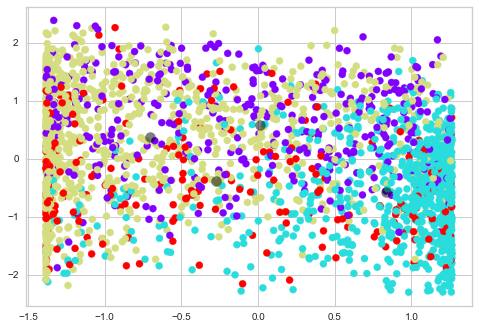

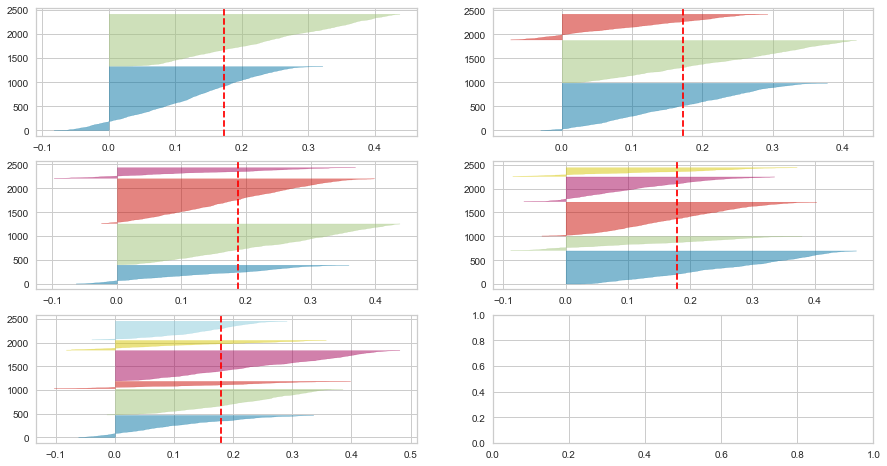

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics.cluster import rand_score

X = pd.concat([X_train, X_test])
Y = pd.concat([Y_train, Y_test])

# Standard Scaler scales them such that the distribution centered around 0, with a standard deviation of 1.
scaler = StandardScaler()
# standardization 
X_scaled = scaler.fit_transform(X) 

kmeans = KMeans(n_clusters=4, random_state=0)
labels_pred = kmeans.fit_predict(X_scaled)
centers = kmeans.cluster_centers_
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_pred, s=50, cmap='rainbow')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
# Calculate Silhoutte Score
score = silhouette_score(X_scaled, kmeans.labels_, metric='euclidean')
print(metrics.rand_score(Y.values, labels_pred))

#https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
fig, ax = plt.subplots(3, 2, figsize=(15,8))
range_n_clusters = [2, 3, 4, 5, 6]
for i in range_n_clusters:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state=0)
    labels_pred = km.fit_predict(X_scaled)

    silhouette_avg = metrics.silhouette_score(X_scaled, labels_pred, metric='euclidean')
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_scaled)



#### Random Forests

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# create a Gaussian classifier
random_forest_clf = RandomForestClassifier(n_estimators=300)

# train the model
random_forest_clf.fit(X_train, Y_train)

# prediction on test set
rf_y_pred = random_forest_clf.predict(X_test)

precision_rf, recall_rf, fscore_rf,_ = metrics.precision_recall_fscore_support(Y_test, rf_y_pred, average='weighted')

rf_metrics = {'accuracy' : metrics.accuracy_score(Y_test, rf_y_pred), 
'precision': precision_rf, 
'recall': recall_rf, 
'fscore': fscore_rf, 
'confusion_matrix': metrics.confusion_matrix(Y_test, rf_y_pred)}

print("Accuracy baseline RF:", rf_metrics['accuracy'])
print("Precision baseline RF:", rf_metrics['precision'])
print("Recall baseline RF:", rf_metrics['recall'])
print("F-score baseline RF:", rf_metrics['fscore'])
print("Confusion matrix baseline RF: \n", rf_metrics['confusion_matrix'])

# cnb_scores = cross_validate(random_forest_clf, X, Y, cv=5, scoring=scoring)
# print(cnb_scores)
# print("Accuracy baseline RF mean:", statistics.mean(cnb_scores['test_acc']))
# print("Precision baseline RF mean:", statistics.mean(cnb_scores['test_prec']))
# print("Recall baseline RF mean:", statistics.mean(cnb_scores['test_rec']))
# print("F-score baseline RF mean", statistics.mean(cnb_scores['test_f-score']))


Accuracy baseline RF: 0.7325
Precision baseline RF: 0.7312111129378027
Recall baseline RF: 0.7325
F-score baseline RF: 0.729824298237854
Confusion matrix baseline RF: 
 [[64 12 15  9]
 [ 2 85  1 12]
 [15  3 80  2]
 [13 15  8 64]]


#### XGBoost

In [10]:
import xgboost as xgb
from xgboost import XGBClassifier

xgboost_clf = XGBClassifier(use_label_encoder=True)

#train the model
xgboost_clf.fit(X_train, Y_train)

# prediction on test set
xgboost_preds = xgboost_clf.predict(X_test)

precision_xgb, recall_xgb, fscore_xgb,_ = metrics.precision_recall_fscore_support(Y_test, xgboost_preds, average='weighted')

xgb_metrics = {'accuracy' : metrics.accuracy_score(Y_test, xgboost_preds), 
'precision': precision_xgb, 
'recall': recall_xgb, 
'fscore': fscore_xgb, 
'confusion_matrix': metrics.confusion_matrix(Y_test, xgboost_preds)}

print("Accuracy baseline XGB:", xgb_metrics['accuracy'])
print("Precision baseline XGB:", xgb_metrics['precision'])
print("Recall baseline XGB:", xgb_metrics['recall'])
print("F-score baseline XGB:", xgb_metrics['fscore'])
print("Confusion matrix baseline XGB: \n", xgb_metrics['confusion_matrix'])

# cnb_scores = cross_validate(xgboost_clf, X, Y, cv=5, scoring=scoring)
# print(cnb_scores)
# print("Accuracy baseline XGB mean:", statistics.mean(cnb_scores['test_acc']))
# print("Precision baseline XGB mean:", statistics.mean(cnb_scores['test_prec']))
# print("Recall baseline XGB mean:", statistics.mean(cnb_scores['test_rec']))
# print("F-score baseline XGB mean", statistics.mean(cnb_scores['test_f-score']))



/home/alex/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[19:31:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy baseline XGB: 0.7225
Precision baseline XGB: 0.7212266497718421
Recall baseline XGB: 0.7225
F-score baseline XGB: 0.7207894150628834
Confusion matrix baseline XGB: 
 [[64 12 13 11]
 [ 5 80  1 14]
 [13  3 81  3]
 [12 17  7 64]]


#### SVM

In [11]:
from sklearn import svm

# “one-versus-one” approach for multi-class classification
# param kernel='rbf' is used by default
svm_clf = svm.SVC(decision_function_shape='ovo')

# train the model
svm_clf.fit(X_train, Y_train)

# prediction on test set
svm_y_pred = svm_clf.predict(X_test)

precision_svm, recall_svm, fscore_svm,_ = metrics.precision_recall_fscore_support(Y_test, svm_y_pred, average='weighted')

svm_metrics = {'accuracy' : metrics.accuracy_score(Y_test, svm_y_pred), 
'precision': precision_svm, 
'recall': recall_svm, 
'fscore': fscore_svm, 
'confusion_matrix': metrics.confusion_matrix(Y_test, svm_y_pred)}

print("Accuracy baseline SVM:", svm_metrics['accuracy'])
print("Precision baseline SVM:", svm_metrics['precision'])
print("Recall baseline SVM:", svm_metrics['recall'])
print("F-score baseline SVM:", svm_metrics['fscore'])
print("Confusion matrix baseline SVM: \n", svm_metrics['confusion_matrix'])

# scoring = {'acc': 'balanced_accuracy',
#            'prec': 'precision_weighted',
#            'rec': 'recall_weighted',
#            'f-score': 'f1_weighted'}

# cnb_scores = cross_validate(svm_clf, X, Y, cv=5, scoring=scoring)
# print(cnb_scores)
# print("Accuracy baseline SVM mean:", statistics.mean(cnb_scores['test_acc']))
# print("Precision baseline SVM mean:", statistics.mean(cnb_scores['test_prec']))
# print("Recall baseline SVM mean:", statistics.mean(cnb_scores['test_rec']))
# print("F-score baseline SVM mean", statistics.mean(cnb_scores['test_f-score']))


Accuracy baseline SVM: 0.275
Precision baseline SVM: 0.2547869041290094
Recall baseline SVM: 0.275
F-score baseline SVM: 0.24259239929507836
Confusion matrix baseline SVM: 
 [[ 7 26 24 43]
 [ 6 38 28 28]
 [ 7 42 11 40]
 [ 7 26 13 54]]


In [12]:
#### Naive Bayes

In [13]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, CategoricalNB, BernoulliNB

cnb_clf = GaussianNB()

# train the model
cnb_clf.fit(X_train, Y_train)

# prediction on test set
cnb_pred = cnb_clf.predict(X_test)

print("Categorical Naive Bayes")
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (Y_test != cnb_pred).sum()))

precision_cnb, recall_cnb, fscore_cnb,_ = metrics.precision_recall_fscore_support(Y_test, cnb_pred, average='weighted')

cnb_metrics = {'accuracy' : metrics.accuracy_score(Y_test, cnb_pred), 
'precision': precision_cnb, 
'recall': recall_cnb, 
'fscore': fscore_cnb, 
'confusion_matrix': metrics.confusion_matrix(Y_test, cnb_pred)}

print("Accuracy baseline NB:", cnb_metrics['accuracy'])
print("Precision baseline NB:", cnb_metrics['precision'])
print("Recall baseline NB:", cnb_metrics['recall'])
print("F-score baseline NB:", cnb_metrics['fscore'])
print("Confusion matrix baseline NB: \n", cnb_metrics['confusion_matrix'])


Categorical Naive Bayes
Number of mislabeled points out of a total 400 points : 120
Accuracy baseline NB: 0.7
Precision baseline NB: 0.6978524326481248
Recall baseline NB: 0.7
F-score baseline NB: 0.6956168769647931
Confusion matrix baseline NB: 
 [[63 13 11 13]
 [ 1 87  1 11]
 [19  3 75  3]
 [16 18 11 55]]


### 4.2. Metode de îmbunătățire și evaluare comparativă [4pct]

Pentru fiecare algoritm, explorați metode prin care să îmbunătățiți performanțele de la pasul precedent (cel de realizarea a baseline-ului).

**Îmbunătățire algoritmi** [2 pct]

Aveți în vedere următoarea listă de idei (și nu numai):
* adăugarea de mai multe feature-uri (momentan la baseline s-au folosit doar *audio_features*)
* [preprocesarea datelor](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) (eng. data preprocessing)
* [selectarea atributelor](https://scikit-learn.org/stable/modules/feature_selection.html) (eng. feature selection)
* modificarea hiperparametrilor fiecărui algoritm (e.g. tipul de kernel la SVM, coeficienți de regularizare, numărul de arbori în RandomForest, adâncimea arborilor în RandomForest)
    * **Atenție!**, exemplu de **AȘA NU**: rularea cu un număr maxim de 10 iterații la baseline și 100 de iterații la modelul mai bun.

În *fma_song_info.zip* există și un fișier *features.csv* -- detalii despre acesta se găsesc în repository-ul menționat în secțiunea [Set de date](#scrollTo=67UlrcAdqj3N).

**Evaluare îmbunătățiri** [2 pct]

* Evaluați variantele îmbunătățite ale algoritmilor, folosind 5-fold [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/). Folosiți aceleași metrici ca în cazul baseline-ului.  **Atenție!** Pentru cross-validation trebuie să vă refaceti împartirea in train/test a setului de date.
* Realizați grafice în care să arătați analiza intra-algoritm a performanței îmbunătățirii (e.g. folosiți un bar chart pentru a compara accuracy-ul variantei baseline a RandomForest cu cea a variantei îmbunătățite).
* Realizați grafice în care să arătați analiza inter-algoritm a performanțelor. Faceți câte un grafic per metrică (e.g. accuracy, precision, recall) în care să încludeți valorile obținute de fiecare algoritm îmbunătățit în parte. 
* Redactați, pe seama graficelor, o analiză a acestora, evidențiind avantajele și dezavantajele fiecărui algoritm implementat.

In [14]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import KFold
import statistics
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.feature_selection import SelectFromModel

In [15]:
features_list = ['audio_features', 'social_features']
X_train_2f = echonest.loc[train, ('echonest', features_list)]
X_test_2f= echonest.loc[test, ('echonest', features_list)]

X_2f = pd.concat([X_train_2f, X_test_2f])

X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(X_2f, Y, test_size=0.2)

In [16]:
all_features_list = ['audio_features', 'social_features', 'temporal_features']
X_train_all = echonest.loc[train, ('echonest', all_features_list)]
X_test_all = echonest.loc[test, ('echonest', all_features_list)]

X_all = pd.concat([X_train_all, X_test_all])

In [17]:
scoring = {'acc': 'balanced_accuracy',
           'prec': 'precision_weighted',
           'rec': 'recall_weighted',
           'f-score': 'f1_weighted'}

In [18]:
### Imbunatatire KMeans

0.7003025566208142


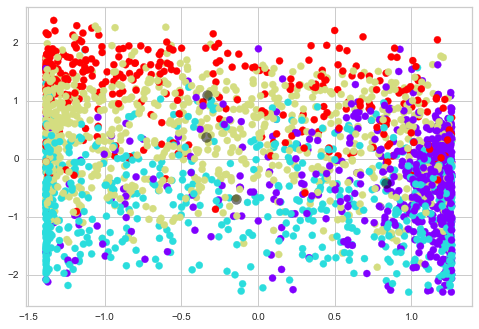

In [19]:
X_all_scaled = scaler.fit_transform(X_all) 

kmeans = KMeans(n_clusters=4, random_state=0)

X_best_km = SelectKBest(f_classif, k=60).fit_transform(X_all_scaled, Y)

kmeans_all_pred = kmeans.fit_predict(X_best_km)

centers = kmeans.cluster_centers_
plt.scatter(X_best_km[:, 0], X_best_km[:, 1], c=kmeans_all_pred, s=50, cmap='rainbow')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

print(metrics.rand_score(Y.values, kmeans_all_pred))


In [20]:
### Imbunatatire RandomForest

In [21]:
# fine tuning hyperparameters for Random Forest
def get_best_hyperparams_rf():
    rf = RandomForestClassifier()
    parameters_rf = {'n_estimators': [400, 500, 600], 
                'max_features': ['auto'], 
                'criterion': ['entropy', 'gini'],
                'max_depth': [5, 10]
                }

    # Run the grid search
    grid_obj = GridSearchCV(estimator=rf, param_grid=parameters_rf, cv=5)
    grid_obj = grid_obj.fit(X_train_new, Y_train_new)

    # Set the rf to the best combination of parameters
    improved_rf = grid_obj.best_estimator_
    print(improved_rf)


In [22]:
#https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

#create a classifier
improved_rf = RandomForestClassifier(n_estimators=500, max_depth=10)

X_best_rf = SelectKBest(f_classif, k=10).fit_transform(X_2f, Y)

print(X_best_rf.shape)
print(Y.shape)
# apply 5-fold cross-validation
kf = KFold(shuffle=True, n_splits=5)

# improved_rf_scores = cross_validate(improved_rf, X_best_rf, Y, cv=kf, scoring=scoring)

# print("Accuracy RF Improved mean:", statistics.mean(improved_rf_scores['test_acc']))
# print("Precision RF Improved mean:", statistics.mean(improved_rf_scores['test_prec']))
# print("Recall RF Improved mean:", statistics.mean(improved_rf_scores['test_rec']))
# print("F-score RF Improved mean", statistics.mean(improved_rf_scores['test_f-score']))

conf_matrix_list_of_arrays = []
for train_index, test_index in enumerate(kf.split(X_best_rf)):

   X_tr, X_tst = X_best_rf[train_index], X_best_rf[test_index]
   y_tr, y_tst = X_best_rf[train_index], Y[test_index]

   improved_rf.fit(X_tr, y_tr)
   conf_matrix = confusion_matrix(y_test, model.predict(X_tst))
   conf_matrix_list_of_arrays .append(conf_matrix)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)
print(mean_of_conf_matrix_arrays)


(2400, 10)
(2400,)


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (1920,) (480,) 

In [55]:
### Imbunatatire SVM

In [56]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

# Find best estimator by GridSearchCV

def find_best_hyperparams_svm():
    print("Fitting the classifier to the training set")
    param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf','linear'], 'decision_function_shape':['ovo']}

    clf = GridSearchCV(estimator=svm.SVC(class_weight='balanced'), param_grid=param_grid, cv=5)
    clf = clf.fit(X_train_new, Y_train_new)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

In [35]:
linear_svm = svm.SVC(kernel='linear', C=1, class_weight='balanced', decision_function_shape='ovo')

X_svm_best = SelectKBest(f_classif, k=10).fit_transform(X_2f, Y)

kf = KFold(shuffle=True, n_splits=5)

improved_svm_scores = cross_validate(linear_svm, X_svm_best, Y, cv=kf, scoring=scoring)

print("Accuracy Linear Kernel SVM mean:", statistics.mean(improved_svm_scores['test_acc']))
print("Precision Linear Kernel SVM mean:", statistics.mean(improved_svm_scores['test_prec']))
print("Recall Linear Kernel SVM mean:", statistics.mean(improved_svm_scores['test_rec']))
print("F-score Linear Kernel SVM mean", statistics.mean(improved_svm_scores['test_f-score']))

Accuracy Linear Kernel SVM mean: 0.6649590218528956
Precision Linear Kernel SVM mean: 0.6728155037836724
Recall Linear Kernel SVM mean: 0.6654166666666667
F-score Linear Kernel SVM mean 0.6644858108365406


In [58]:
### Imbunatatire XGBoost

In [259]:
def find_best_hyperparams_xgboost():

    # print("Fitting the classifier to the training set")
    param_test = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
    }

    improved_xgboost_clf = GridSearchCV(estimator=XGBClassifier(use_label_encoder=True), param_grid=param_test, cv=5)
    improved_xgboost_clf = improved_xgboost_clf.fit(X_train_new, Y_train_new)
    print("Best estimator found by grid search:")
    print(improved_xgboost_clf.best_estimator_)

    
find_best_hyperparams_xgboost()

ost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/home/alex/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[21:02:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/home/alex/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of labe

In [177]:
improved_xgboost_clf = XGBClassifier(use_label_encoder=True, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=9,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [175]:

def plot_xgboost_feature_importance():
    improved_xgboost_clf.fit(X_train_new, Y_train_new)

    sorted_indices = np.argsort(improved_xgboost_clf.feature_importances_)[::-1]
    print(sorted_indices)

    feature_names = [X_2f.columns[i][2] for i in range(X_2f.shape[1])]
    plt.barh(feature_names, improved_xgboost_clf.feature_importances_)
    plt.xlabel("XGB Feature Importance")

In [179]:
X_best_xgb = SelectKBest(f_classif, k=10).fit_transform(X_2f, Y)

kf = KFold(shuffle=True, n_splits=5)

improved_XGB_scores = cross_validate(improved_xgboost_clf, X_best_xgb, Y, cv=kf, scoring=scoring)

print("Accuracy XGB Improved mean:", statistics.mean(improved_XGB_scores['test_acc']))
print("Precision XGB Improved mean:", statistics.mean(improved_XGB_scores['test_prec']))
print("Recall XGB Improved mean:", statistics.mean(improved_XGB_scores['test_rec']))
print("F-score XGB Improved mean", statistics.mean(improved_XGB_scores['test_f-score']))

/home/alex/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[19:05:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/home/alex/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifie

In [61]:
### Imbunatatire Naive Bayes

In [253]:
def tune_hyperparams_NB():
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    gs_NB = GridSearchCV(estimator=GaussianNB(), param_grid=params_NB, cv=5,verbose=1,scoring='accuracy')
    gs_NB = gs_NB.fit(X_train, Y_train)
    print("Best estimator found by grid search:")
    print(gs_NB.best_estimator_)
    return gs_NB.best_estimator_

In [72]:
improved_gnb_clf = GaussianNB(var_smoothing=2.310129700083158e-06)

kf = KFold(shuffle=True, n_splits=5)

improved_XGB_scores = cross_validate(improved_gnb_clf, X, Y, cv=kf, scoring=scoring)

print("Accuracy improved NB mean:", statistics.mean(improved_XGB_scores['test_acc']))
print("Precision improved NB mean:", statistics.mean(improved_XGB_scores['test_prec']))
print("Recall improved NB mean:", statistics.mean(improved_XGB_scores['test_rec']))
print("F-score improved NB mean", statistics.mean(improved_XGB_scores['test_f-score']))

# precision_gnb, recall_gnb, fscore_gnb,_ = metrics.precision_recall_fscore_support(Y_test, gnb_pred, average='weighted')

# gnb_metrics = {'accuracy' : metrics.accuracy_score(Y_test, gnb_pred), 
# 'precision': precision_gnb, 
# 'recall': recall_gnb, 
# 'fscore': fscore_gnb, 
# 'confusion_matrix': metrics.confusion_matrix(Y_test, gnb_pred)}

# print("Accuracy improved NB:", gnb_metrics['accuracy'])
# print("Precision improved NB:", gnb_metrics['precision'])
# print("Recall improved NB:", gnb_metrics['recall'])
# print("F-score improved NB:", gnb_metrics['fscore'])
# print("Confusion matrix improved NB: \n", gnb_metrics['confusion_matrix'])


Accuracy improved NB mean: 0.6446393465853102
Precision improved NB mean: 0.6478679476042309
Recall improved NB mean: 0.64375
F-score improved NB mean 0.6420557842633994


## 5. Mențiuni

**Pentru rezolvarea task-urilor puteți folosi orice bibliotecă doriți.**

În scheletul temei, datele sunt încărcate folosind biblioteca [pandas](https://pandas.pydata.org/), însă puteți utiliza orice bibliotecă doriți.

**Algoritmii nu trebuie implementați de mână.**

"Rezolvarea" unei probleme de învățare automată se reduce la îmbunătățirea unei metrici.

Un prim pas important este reprezentat de crearea unui *baseline* sau a unei soluții banale, de start (eng. *vanilla solution*) și măsurarea acesteia.

Următorul pas îl reprezintă o serie de modificări aduse feature setului sau algoritmului de învățăre. Aceast pas reprezintă o iterație peste soluția inițială.

Tot procesul constă în aplicarea mai multor *iterații* până se ajunge la o valoare a metricii suficient de bună pentru problema de rezolvat. În cazul nostru, această valoare este reprezentată de ambiția fiecăruia dintre voi :)

**Recomandări**:
* biblioteca [sklearn](https://scikit-learn.org/) - oferă o colecție algoritmi de învățare automată, metrici, metode de selectare de caractaristici, etc.
* pentru XGBoost puteți folosit biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/)

## 6. Sample test
Biblioteca [librosa](https://librosa.github.io/librosa/) permite analizarea și redarea sunetelor.

Se poate folosi pentru a observa dacă anumite melodii găsite într-un anumit gen muzical sunt asemănătoare.

In [19]:
track_test = tracks[test].sample(1)
title = track_test[('track', 'title')].values[0]
genre = track_test[('track', 'genre_top')].values[0]
print(f"Song\n\ttitle: {title}\n\tgenre {genre}")

song_path = get_song_path(track_test.index.values[0])
song, rate = librosa.load(song_path)
ipd.Audio(song, rate=rate)

Song
	title: B 6 Ce matin
	genre Folk
/home/alex/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


## 7. Link-uri utile
* [Evaluarea algoritmilor de clusterizare](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)
* [Standardizare vs Normalizare](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc)

## Bibliografie
<a name="fma">[1] *Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, FMA: A Dataset For Music Analysis, 18th International Society for Music Information Retrieval Conference, 2017*</a>

